In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run get_odds.py
%run Helper.py

In [3]:
class league_bru():
    def __init__(self, teams=None, p_alpha=None, q_alpha=None, alpha_hat=None, p_beta=None, q_beta=None, beta_hat=None,
                p_gamma=None, q_gamma=None, gamma_hat=None, w=0.9879 , w_b=0.77767, w3=0.9984992, delta=10, 
                 delta_g=713.4048222, 
                 promoted=dict({'p_alpha':44.28, 'q_alpha':53.71, 'p_beta':43.43, 'q_beta':39.29, 
                           'p_gamma':1.4*713.4048222, 'q_gamma':713.4048222}), 
                 relegated=dict({'p_alpha':53.71, 'q_alpha':44.28, 'p_beta':39.29, 'q_beta':43.43, 
                           'p_gamma':1.4*713.4048222, 'q_gamma':713.4048222}), trained_data=pd.DataFrame()):
        self.teams = teams
        if self.teams:
            self.NT = len(teams)
        self.p_alpha = p_alpha
        self.q_alpha = q_alpha
        self.alpha_hat = alpha_hat
        self.p_beta = p_beta
        self.q_beta = q_beta
        self.beta_hat = beta_hat
        self.p_gamma = p_gamma
        self.q_gamma = q_gamma
        self.gamma_hat = gamma_hat
        self.w = w
        self.w3 = w3
        self.w_b = w_b
        self.delta = delta
        self.delta_g = delta_g
        self.promoted = promoted
        self.relegated = relegated
        self.trained_data = trained_data
    
    def initialise(self, teams):
        self.teams = teams
        self.NT = len(teams)
        self.p_alpha = np.array([self.delta]*self.NT, dtype=float)
        self.q_alpha = np.array([self.delta]*self.NT, dtype=float)
        self.alpha_hat = (self.p_alpha)/self.q_alpha
        
        self.p_beta = np.array([self.delta]*self.NT, dtype=float)
        self.q_beta = np.array([self.delta]*self.NT, dtype=float)
        self.beta_hat = self.p_beta/self.q_beta
        
        self.p_gamma = np.array([1.45*self.delta_g]*self.NT, dtype=float)
        self.q_gamma = np.array([self.delta_g]*self.NT, dtype=float)
        self.gamma_hat = (self.p_gamma-1)/self.q_gamma
    
    def train(self, data):
        data.loc[data['FTHG'] > 5, 'FTHG'] = 5
        data.loc[data['FTAG'] > 5, 'FTAG'] = 5
        
        data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
        
        lambdasH = []
        lambdasA = []
        # iterate through data
        for i in range(data.shape[0]):
            match = data.iloc[[i]]
            # get indices of home and away sides
            HT = int(np.arange(self.NT)[self.teams==match.iloc[0].loc['HomeTeam']])
            AT = int(np.arange(self.NT)[self.teams==match.iloc[0].loc['AwayTeam']])
            # get home and away lambda
            lambdaH = self.alpha_hat[HT]*self.beta_hat[AT]*self.gamma_hat[HT]
            lambdasH.append(lambdaH)
            
            lambdaA = self.alpha_hat[AT]*self.beta_hat[HT]
            lambdasA.append(lambdaA)
            
            X = int(match['FTHG'])
            Y = int(match['FTAG'])
            
            self.p_alpha[HT] = self.w*self.p_alpha[HT]+X
            self.q_alpha[HT] = self.w*self.q_alpha[HT]+self.beta_hat[AT]*self.gamma_hat[HT]
            self.alpha_hat[HT] = (self.p_alpha[HT]-1)/self.q_alpha[HT]

            self.p_alpha[AT] = self.w*self.p_alpha[AT]+Y
            self.q_alpha[AT] = self.w*self.q_alpha[AT]+self.beta_hat[HT]
            self.alpha_hat[AT] = (self.p_alpha[AT]-1)/self.q_alpha[AT]

            self.p_beta[HT] = self.w*self.p_beta[HT]+Y
            self.q_beta[HT] = self.w*self.q_beta[HT]+self.alpha_hat[AT]
            self.beta_hat[HT] = (self.p_beta[HT]-1)/self.q_beta[HT]

            self.p_beta[AT] = self.w*self.p_beta[AT]+X
            self.q_beta[AT] = self.w*self.q_beta[AT]+self.alpha_hat[HT]*self.gamma_hat[HT]
            self.beta_hat[AT] = (self.p_beta[AT]-1)/self.q_beta[AT]

            self.p_gamma[HT] = self.w3*self.p_gamma[HT]+X
            self.q_gamma[HT] = self.w3*self.q_gamma[HT]+self.alpha_hat[HT]*self.beta_hat[AT]
            self.gamma_hat[HT] = (self.p_gamma[HT]-1)/self.q_gamma[HT]
        
        phome = 1 - skellam.cdf(0, lambdasH, lambdasA)
        pdraw = skellam.pmf(0, lambdasH, lambdasA)
        paway = 1-phome-pdraw
        P = np.zeros((len(data), 3))
        P[:,0] = phome
        P[:,1] = pdraw
        P[:,2] = paway
        Z = FTRtoZ(data['FTR'])
        data['BS'] = BS(Z, P)
        #data['LS'] = LS(Z, P)
        data['PHome'] = phome
        data['PDraw'] = pdraw
        data['PAway'] = paway
        data['LambdaH'] = lambdasH
        data['LambdaA'] = lambdasA
        
        self.trained_data = self.trained_data.append(data, ignore_index=True) 

    def predict(self, HomeTeam, AwayTeam):
        HT = int(np.arange(self.NT)[self.teams==HomeTeam])
        AT = int(np.arange(self.NT)[self.teams==AwayTeam])
        LambdaH = self.alpha_hat[HT]*self.beta_hat[AT]*self.gamma_hat[HT]
        LambdaA = self.alpha_hat[AT]*self.beta_hat[HT]
        
        home_goals = np.zeros(9)
        away_goals = np.zeros(9)
        for i in range(8):
            home_goals[i] = poisson.pmf(i, LambdaH)
            away_goals[i] = poisson.pmf(i, LambdaA)
        home_goals[8] = 1-sum(home_goals)
        away_goals[8] = 1-sum(away_goals)
        scores = np.zeros((9,9))
        for i in range(9):
            for j in range(9):
                scores[i,j] = home_goals[i]*away_goals[j]
        
        phome = np.tril(scores, -1).sum()
        pdraw = sum(np.diag(scores))
        paway = np.triu(scores, 1).sum()
        
        # most likely result
        result = np.where(scores==np.max(scores))
        result = list(result)
        ml_result = [int(result[0]), int(result[1])]
        
        return({'matrix':scores, 'outcomes':[phome, pdraw, paway], 'result':ml_result})
    
    def predict_lambdas(self, LambdaH, LambdaA):
        home_goals = np.zeros(9)
        away_goals = np.zeros(9)
        for i in range(8):
            home_goals[i] = poisson.pmf(i, LambdaH)
            away_goals[i] = poisson.pmf(i, LambdaA)
        home_goals[8] = 1-sum(home_goals)
        away_goals[8] = 1-sum(away_goals)
        scores = np.zeros((9,9))
        for i in range(9):
            for j in range(9):
                scores[i,j] = home_goals[i]*away_goals[j]
        
        phome = np.tril(scores, -1).sum()
        pdraw = sum(np.diag(scores))
        paway = np.triu(scores, 1).sum()
        
        # most likely result
        result = np.where(scores==np.max(scores))
        result = list(result)
        ml_result = [int(result[0]), int(result[1])]
        
        return({'matrix':scores, 'outcomes':[phome, pdraw, paway], 'result':ml_result})
    
    def new_season(self, teams_out, teams_promoted_in, teams_relegated_in=None):
        # record variables belonging to each team
        tracker=dict({'teams':self.teams, 'p_alpha':self.p_alpha, 'q_alpha':self.q_alpha, 'p_beta':self.p_beta, 
                      'q_beta':self.q_beta, 'p_gamma':self.p_gamma, 'q_gamma':self.q_gamma})
        teams_df = pd.DataFrame(tracker)
        # remove teams exiting league
        teams_out_index = []
        for i in range(len(self.teams)):
            if self.teams[i] in teams_out:
                teams_out_index.append(i)
        self.teams = np.delete(self.teams, teams_out_index)
        # add new teams to the league
        self.teams = np.append(self.teams, teams_promoted_in)
        if teams_relegated_in:
            self.teams = np.append(self.teams, teams_relegated_in)
        self.teams = np.array(sorted(self.teams))

        self.p_alpha = np.array([])
        self.q_alpha = np.array([])
        self.p_beta = np.array([])
        self.q_beta = np.array([])
        self.p_gamma = np.array([])
        self.q_gamma = np.array([])
        for i in range(self.NT):
            if self.teams[i] in list(teams_df['teams']):
                team_data = teams_df[teams_df['teams']==self.teams[i]]
                w_b = self.w_b
                w3 = self.w3
            elif self.teams[i] in list(teams_promoted_in):
                team_data = self.promoted
                w_b = 1
                w3 = 1
            elif self.teams[i] in list(teams_relegated_in):
                team_data = self.relegated
                w_b = 1
                w3 = 1
                
            self.p_alpha = np.append(self.p_alpha, w_b*float(team_data['p_alpha']))
            self.q_alpha = np.append(self.q_alpha, w_b*float(team_data['q_alpha']))
            self.p_beta = np.append(self.p_beta, w_b*float(team_data['p_beta']))
            self.q_beta = np.append(self.q_beta, w_b*float(team_data['q_beta']))
            self.p_gamma = np.append(self.p_gamma, w3* float(team_data['p_gamma']))
            self.q_gamma = np.append(self.q_gamma, w3*float(team_data['q_gamma']))
            
        self.alpha_hat = (self.p_alpha-1)/self.q_alpha
        self.beta_hat = (self.p_beta-1)/self.q_beta
        self.gamma_hat = (self.p_gamma-1)/self.q_gamma
        
    def train_all(self, league_str, league_below=None, league_above=None, SEA = list(range(1996, 2021))):
        NS = []
        NS_below = []
        NS_above = []
        for i in SEA:
            NS.append('AutoData/'+str(i)+league_str+'.csv')
            if league_below:
                NS_below.append('AutoData/'+str(i)+league_below+'.csv')
            if league_above:
                NS_above.append('AutoData/'+str(i)+str(league_above)+'.csv')
        
        data = pd.read_csv(NS[0])
        data = data[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
        teams = np.unique(data['HomeTeam'])
        
        self.teams = teams
        self.NT = len(teams)

        if league_below:
            data_below = pd.read_csv(NS_below[0])
            data_below = data_below[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            teams_below = np.unique(data_below['HomeTeam'])

        if league_above:
            data_above = pd.read_csv(NS_above[0])
            data_above = data_above[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            teams_above = np.unique(data_above['HomeTeam'])

        print('Season: ' + str(SEA[0]), end="\r")
        self.initialise(teams)
        self.train(data)
        matches = data.shape[0]
        seasons = [SEA[0]]*matches
        promoted_in=None
        relegated_in=None
        for i in range(1, len(NS)):
            print('Season: ' + str(SEA[i]), end="\r")
            old_data = data
            old_teams = teams    
            data = pd.read_csv(NS[i], encoding = 'unicode_escape')
            data = data[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            matches = data.shape[0]
            seasons = np.append(seasons, [SEA[i]]*matches)
            teams = np.unique(data['HomeTeam'])
            teams_out = list(set(old_teams) - set(teams))

            if league_below:
                old_data_below = data_below
                old_teams_below = teams_below
                data_below = pd.read_csv(NS_below[i], encoding = 'unicode_escape')
                data_below = data_below[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
                teams_below = np.unique(data_below['HomeTeam'])

            if league_above:
                old_data_above = data_above
                old_teams_above = teams_above
                data_above = pd.read_csv(NS_above[i], encoding = 'unicode_escape')
                data_above = data_above[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
                teams_above = np.unique(data_above['HomeTeam'])

            if league_below:
                promoted_in =  sorted(list(set(old_teams_below) & set(teams)))
            if league_above:
                relegated_in = sorted(list(set(old_teams_above) & set(teams)))
                
            if not (league_below or league_above):
                promoted_in =  sorted(list(set(teams) - set(old_teams)))

            #print('Teams Out:' + str(teams_out))
            #print('Promoted In:' + str(promoted_in))
            self.new_season(teams_out, promoted_in, relegated_in)
            self.train(data)
        self.trained_data.insert(0, 'SEA', seasons)
        print('Training Complete')
    
    def betting_odds(self, league_str, SEA=list(range(2006, 2022))):
        NS = []
        for i in SEA:
            NS.append('BettingData/'+str(i)+league_str+'.csv')
        j=0
        for i in range(len(NS)):
            if SEA[i] < 2020:
                newdata = pd.read_csv(NS[i])
            else:
                newdata = pd.read_csv(NS[i])
                columns = list(newdata.columns)
                for j in range(len(columns)):
                    column = columns[j]
                    columns[j] = re.sub('Max', 'BbMx', column)
                newdata.columns = columns
            
            newdata['Date'] = pd.to_datetime(newdata['Date'], dayfirst=True)
            newdata.insert(1, 'SEA', SEA[i])
                
            if j==0:
                data = newdata[['Div', 'SEA', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'BbMxH', 'BbMxD', 'BbMxA']]
            else:
                data = data.append(newdata[['Div', 'SEA', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'BbMxH', 'BbMxD', 'BbMxA']], 
                                  ignore_index=True)
            j += 1
        data['BetHome'] = 1/data['BbMxH']
        data['BetDraw'] = 1/data['BbMxD']
        data['BetAway'] = 1/data['BbMxA']
        return data

## Update Data

In [4]:
# football data
url = "https://www.football-data.co.uk/mmz4281/"
ext = ['E0'] #, 'E1', 'E2', 'E3', 'SP1', 'SP2', 'SC0', 'D1', 'D2', 
       #'I1', 'SP1', 'SP2', 'F1', 'N1', 'B1', 'P1', 'T1', 'G1']
year = 2023
prev_year = str(year-1)
year = str(year)
year_string = prev_year[2:]+year[2:]

for league in ext:
    full_url = url + year_string + '/' + league + '.csv'
    #display(full_url)
    r = requests.get(full_url, allow_redirects=True)
    open('AutoData/'+year+league+'.csv', 'wb').write(r.content)
    data = read_football_data('AutoData/'+year+league+'.csv')
    data.to_csv('AutoData/'+year+league+'.csv', index=False)
# betting data 
ext = ['E0'] #, 'SP1', 'SC0', 'D1', 'I1', 'F1', 'N1', 'B1', 'P1']
year = 2223
prev_year = str(year-1)
year = str(year)
int(year[2:])
year_string = prev_year[2:]+year[2:]

for league_name in ext:
    full_url = url + year_string + '/' + league_name + '.csv'
    #display(full_url)
    r = requests.get(full_url, allow_redirects=True)
    open('BettingData/'+year+league_name+'.csv', 'wb').write(r.content)
    data = read_betting_data('BettingData/'+year+league_name+'.csv')
    data.to_csv('BettingData/'+year+league_name+'.csv', index=False)

In [5]:
# train up to 2020/2021 season
PL = league_bru()
PL.train_all(league_str='E0', SEA=list(range(1996, 2021)))
# account for covid, no home advantage, train in 2020/2021 season
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2021/E0.csv")
PL.new_season(teams_out=['Bournemouth', 'Norwich', 'Watford'], teams_promoted_in=['Fulham','Leeds', 'West Brom'])
PL.p_gamma = np.array([101]*20, dtype=float)
PL.q_gamma = np.array([100]*20, dtype=float)
PL.gamma_hat = (PL.p_gamma-1)/PL.q_gamma
PL.train(new_data)
PL.trained_data.loc[9500:, 'SEA'] = 2021
# adjust for being back to normal, home team advantage is back, train 2021/2022 season
PL.p_alpha =PL.p_alpha * 0.99
PL.p_beta =PL.p_beta * 0.99
PL.q_alpha =PL.q_alpha * 0.99
PL.q_beta =PL.q_beta * 0.99
PL.new_season(teams_out=['Fulham', 'Sheffield United', 'West Brom'], teams_promoted_in=['Brentford','Norwich', 'Watford'])
PL.p_gamma = np.array([141]*20, dtype=float)
PL.q_gamma = np.array([100]*20, dtype=float)
PL.gamma_hat = (PL.p_gamma-1)/PL.q_gamma
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv")
PL.train(new_data)
PL.trained_data.loc[9880:, 'SEA'] = 2022
# train 2022/2023 season
PL.new_season(teams_out=['Norwich', 'Watford', 'Burnley'], teams_promoted_in=['Fulham',"Nott'm Forest", 'Bournemouth'])
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/E0.csv")
PL.train(new_data)
PL.trained_data.loc[10260:, 'SEA'] = 2023
PL.trained_data.tail(10)
# train 2023/2024 season
PL.new_season(teams_out=['Leicester', 'Southampton', 'Leeds'], teams_promoted_in=['Luton','Burnley', 'Sheffield United'])
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2324/E0.csv")
PL.train(new_data)
PL.trained_data.loc[10640:, 'SEA'] = 2024
PL.trained_data.tail(10)

Training Complete


,SEA,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,BS,PHome,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
10790,2024.0,E0,2023-12-09,Crystal Palace,Liverpool,1,2,A,0.286124,0.195611,...,2.25,1.00,2.07,1.83,2.10,1.84,2.19,1.87,2.08,1.80
10791,2024.0,E0,2023-12-09,Brighton,Burnley,1,1,D,1.298971,0.754109,...,2.22,-1.00,1.94,1.99,1.92,2.01,1.94,2.28,1.87,2.01
10792,2024.0,E0,2023-12-09,Man United,Bournemouth,0,3,A,1.276963,0.682991,...,2.71,-1.00,2.05,1.75,2.11,1.81,2.17,1.95,2.08,1.80
10793,2024.0,E0,2023-12-09,Sheffield United,Brentford,1,0,H,0.899324,0.238885,...,1.95,0.75,1.91,2.02,1.91,2.02,1.93,2.06,1.87,1.99
10794,2024.0,E0,2023-12-09,Wolves,Nott'm Forest,1,1,D,0.856666,0.516304,...,1.59,-0.50,1.99,1.94,2.00,1.93,2.00,2.02,1.93,1.95
10795,2024.0,E0,2023-12-09,Aston Villa,Arsenal,1,0,H,0.549221,0.399614,...,2.12,0.50,1.90,2.03,1.90,2.03,1.91,2.07,1.86,2.02
10796,2024.0,E0,2023-12-10,Everton,Chelsea,2,0,H,0.731274,0.307265,...,1.97,0.00,1.84,2.06,1.85,2.09,1.93,2.13,1.84,2.03
10797,2024.0,E0,2023-12-10,Fulham,West Ham,5,0,H,0.473931,0.439323,...,2.04,-0.25,1.88,2.02,1.90,2.02,1.99,2.06,1.90,1.96
10798,2024.0,E0,2023-12-10,Luton,Man City,1,2,A,0.092313,0.091068,...,2.47,2.00,1.87,2.03,1.87,2.04,1.92,2.07,1.87,2.00
10799,2024.0,E0,2023-12-10,Tottenham,Newcastle,4,1,H,0.410979,0.477846,...,2.62,-0.25,1.73,2.08,1.81,2.12,1.89,2.16,1.81,2.06


In [6]:
odds = get_odds()

Remaining requests 496
Used requests 4


This approach returns the result with the greatest likelihood of occuring. We want the result which maximises SuperBru points. We will iterate through each scoreline and calculate the expected SuperBru points according to our probability distribution.

In [7]:
convert_names = {'Arsenal': 'Arsenal', 'Aston Villa': 'Aston Villa',
                 'Bournemouth': 'Bournemouth', 'Brentford': 'Brentford', 
                 'Brighton and Hove Albion': 'Brighton', 'Burnley': 'Burnley',
                 'Chelsea': 'Chelsea', 'Crystal Palace': 'Crystal Palace',
                 'Everton': 'Everton', 'Fulham': 'Fulham', 'Leeds United': 'Leeds',
                 'Leicester City': 'Leicester', 'Liverpool': 'Liverpool',
                 'Luton': 'Luton',
                 'Manchester City': 'Man City', 'Manchester United': 'Man United',
                 'Newcastle United': 'Newcastle', 'Norwich City': 'Norwich',
                 'Nottingham Forest': "Nott'm Forest",
                 'Sheffield United': 'Sheffield United', 'Southampton': 'Southampton', 
                 'Tottenham Hotspur': 'Tottenham', 'Watford': 'Watford', 
                 'West Bromwich Albion': 'West Brom', 'West Ham United': 'West Ham',
                 'Wolverhampton Wanderers': 'Wolves'}
new_exp_points = 0
prev_exp_points = 0

for match in odds[:20]:
    HomeTeam = convert_names[match['match'][0]]
    AwayTeam = convert_names[match['match'][1]]
    print(HomeTeam + ' vs ' + AwayTeam, end="", flush=True)
    prediction = PL.predict(HomeTeam, AwayTeam)
    exp_points = np.zeros((6,6))
    for home in range(6):
        for away in range(6):
            exp_points[home, away] = sum(sum(get_points_matrix(home,away)*prediction['matrix']))
    
    result = np.where(exp_points==np.max(exp_points))
    result = list(result)
    new_exp_points += np.max(exp_points)
    prev_exp_points += exp_points[prediction['result'][0], prediction['result'][1]]
    ml_result = [int(result[0]), int(result[1])]
    print(' '*(40-len(HomeTeam + ' vs ' + AwayTeam)) + str(ml_result[0]) + '-' + str(ml_result[1]))#+', '+' '*20+'Previous Prediction: ' + str(prediction['result'][0]) + '-' + str(prediction['result'][1]))
print("")
print('Expected points: {}, Previous Expected Points: {}'.format(round(new_exp_points, 3), round(prev_exp_points,3)))
print('Change in Expected Points of {}'.format(round(new_exp_points-prev_exp_points, 3)))

Nott'm Forest vs Tottenham              1-2
Newcastle vs Fulham                     2-0
Bournemouth vs Luton                    2-0
Man City vs Crystal Palace              2-0
Chelsea vs Sheffield United             2-0
Burnley vs Everton                      0-1
West Ham vs Wolves                      2-0
Arsenal vs Brighton                     3-1
Brentford vs Aston Villa                2-1
Liverpool vs Man United                 2-0
Crystal Palace vs Brighton              1-2
Aston Villa vs Sheffield United         2-0
West Ham vs Man United                  2-1
Luton vs Newcastle                      0-2
Nott'm Forest vs Bournemouth            1-0
Fulham vs Burnley                       2-0
Tottenham vs Everton                    2-0
Liverpool vs Arsenal                    2-1
Wolves vs Chelsea                       0-1

Expected points: 17.467, Previous Expected Points: 15.481
Change in Expected Points of 1.986


In [8]:
pd.DataFrame({"teams":PL.teams, "att_str":PL.alpha_hat, "def_str":PL.beta_hat, "home_adv":PL.gamma_hat})

,teams,att_str,def_str,home_adv
0,Arsenal,1.730436,0.781750,1.468999
1,Aston Villa,1.354128,0.862234,1.506921
2,Bournemouth,0.939181,1.141544,1.397613
3,Brentford,1.143322,0.908684,1.468169
4,Brighton,1.432713,0.987699,1.418383
5,Burnley,0.828738,1.209864,1.401244
6,Chelsea,1.304763,0.866135,1.280924
7,Crystal Palace,0.943129,0.933555,1.345908
8,Everton,0.985328,0.995648,1.340400
9,Fulham,1.164659,0.990412,1.415822


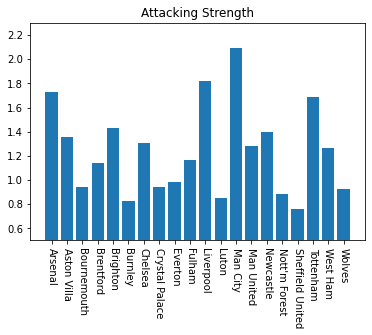

In [9]:
import matplotlib.pyplot as plt
plt.bar(x=range(20), height=PL.alpha_hat, tick_label=PL.teams)
plt.xticks(rotation=270)
plt.ylim(0.5, 2.3)
plt.title('Attacking Strength')
plt.show()

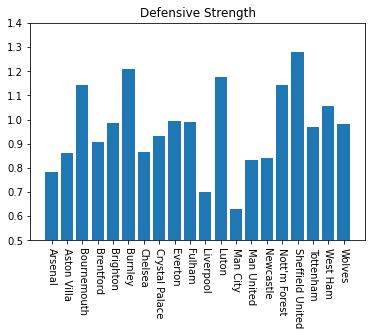

In [10]:
plt.bar(x=range(20), height=PL.beta_hat, tick_label=PL.teams)
plt.xticks(rotation=270)
plt.ylim(0.5, 1.4)
plt.title('Defensive Strength')
plt.show()

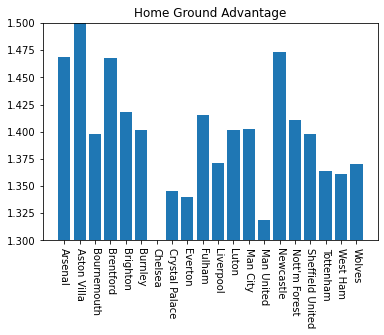

In [11]:
plt.bar(x=range(20), height=PL.gamma_hat, tick_label=PL.teams)
plt.xticks(rotation=270)
plt.ylim(1.3, 1.5)
plt.title('Home Ground Advantage')
plt.show()

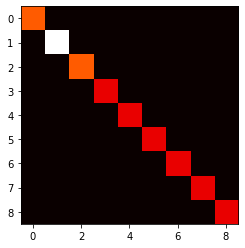

In [12]:
points_matrix = get_points_matrix(1, 1)
plt.imshow(points_matrix, cmap='hot')
#
plt.show()

In [13]:
PL.predict("Aston Villa", "Newcastle")

{'matrix': array([[5.39336888e-02, 6.50917461e-02, 3.92791176e-02, 1.58017893e-02,
         4.76773459e-03, 1.15082123e-03, 2.31484763e-04, 3.99107756e-05,
         6.93768389e-06],
        [9.23946237e-02, 1.11509662e-01, 6.72896546e-02, 2.70702858e-02,
         8.16767873e-03, 1.97148937e-03, 3.96560073e-04, 6.83717574e-05,
         1.18850519e-05],
        [7.91413185e-02, 9.55144498e-02, 5.76374661e-02, 2.31872595e-02,
         6.99608741e-03, 1.68869423e-03, 3.39676550e-04, 5.85643494e-05,
         1.01802317e-05],
        [4.51927327e-02, 5.45424195e-02, 3.29132070e-02, 1.32408158e-02,
         3.99503463e-03, 9.64309269e-04, 1.93968357e-04, 3.34424930e-05,
         5.81330334e-06],
        [1.93550896e-02, 2.33593624e-02, 1.40960290e-02, 5.67076079e-03,
         1.71098867e-03, 4.12993223e-04, 8.30725367e-05, 1.43227110e-05,
         2.48971462e-06],
        [6.63149977e-03, 8.00345589e-03, 4.82962440e-03, 1.94293333e-03,
         5.86224149e-04, 1.41500996e-04, 2.84625655e-05, 